# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [ ]:
import tensorflow as tf
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [ ]:
import cv2
import imghdr
import os
data_dir = '/content/drive/MyDrive/Art Classification/data'

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))

        except Exception as e:
            print('Issue with image {}'.format(image_path))

Image not in ext list /content/drive/MyDrive/Art Classification/data/Rembrandt/Rembrandt_van_Rijn_-_Self-Portrait_-_Google_Art_Project.jpg
Image not in ext list /content/drive/MyDrive/Art Classification/data/Rembrandt/The_Resurrected_Christ_-_Rembrandt.jpg
Image not in ext list /content/drive/MyDrive/Art Classification/data/Rembrandt/Rembrandt-Belsazar.jpg
Image not in ext list /content/drive/MyDrive/Art Classification/data/Rembrandt/The_Holy_Family_-_Rembrandt.jpg
Image not in ext list /content/drive/MyDrive/Art Classification/data/Rembrandt/Workshop_of_Rembrandt_Harmensz._van_Rijn_-_Rembrandt_Harmensz_van_Rijn_(1606-1669)_-_1977.6_-_Fogg_Museum.jpg
Image not in ext list /content/drive/MyDrive/Art Classification/data/Rembrandt/Rembrandt_Harmensz._van_Rijn_058.jpg
Image not in ext list /content/drive/MyDrive/Art Classification/data/Rembrandt/Judith_at_the_Banquet_of_Holofernes_(previously_known_as_Artemisia),_by_Rembrandt,_from_Prado_in_Google_Earth.jpg
Image not in ext list /content/d

# 3. Load Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_dir = '/content/drive/MyDrive/Art Classification/data'
datagen = ImageDataGenerator(rescale=1./255)
data = datagen.flow_from_directory(
    data_dir,
    batch_size=32,
    class_mode='categorical')

Found 40 images belonging to 2 classes.


# 4. Scale and Split Data

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_data.class_indices)
print("Number of classes:", num_classes)

total_samples = train_data.samples + val_data.samples

train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

train = [train_data.next() for _ in range(train_size // 32)]

val = [val_data.next() for _ in range(val_size // 32)]

print("Size of training set:", len(train))
print("Size of validation set:", len(val))

Found 33 images belonging to 2 classes.
Found 7 images belonging to 2 classes.
Number of classes: 2
Size of training set: 0
Size of validation set: 0


In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size
val_size
test_size

0

# 5. Build Deep Learning Model

In [ ]:
train

[]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 6. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
2/2 [==============================] - 4s 825ms/step - loss: 0.7523 - accuracy: 0.5000 - val_loss: 1.4513 - val_accuracy: 0.5000
Epoch 2/20
2/2 [==============================] - 2s 2s/step - loss: 0.7365 - accuracy: 0.5000 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 2s 288ms/step - loss: 0.6963 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 2s 268ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/20
2/2 [==============================] - 2s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 4s 3s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 2s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/20
2/2 [================

# 7. Plot Performance

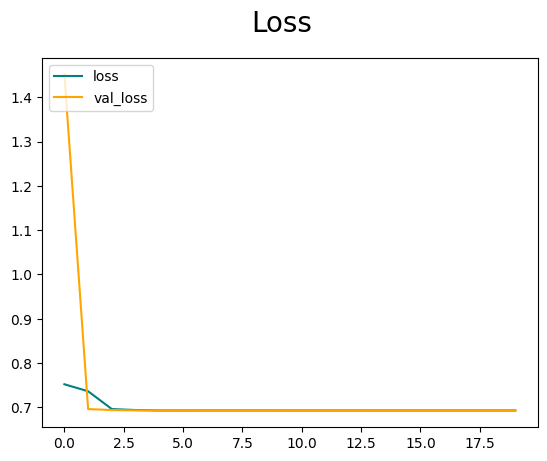

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

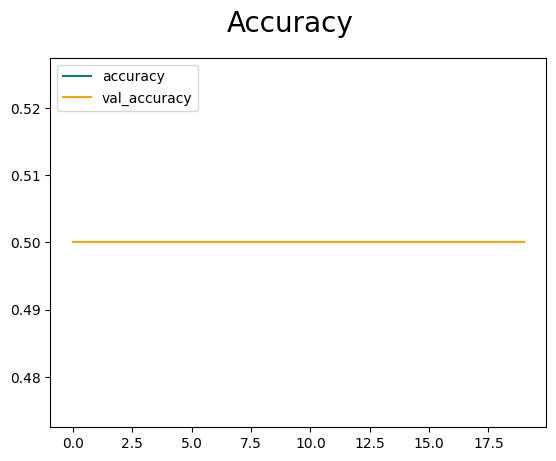

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Evaluate

In [ ]:
#from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
#pre = Precision()
#re = Recall()
#acc = BinaryAccuracy()

In [ ]:
#print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 9. Test

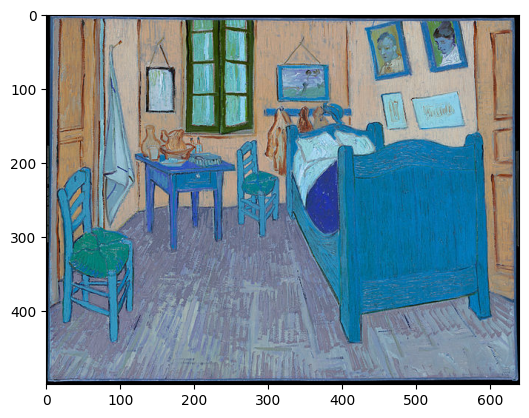

In [ ]:
import cv2
img = cv2.imread('/content/drive/MyDrive/Art Classification/data/Van Gogh/640px-La_Chambre_à_Arles,_by_Vincent_van_Gogh,_from_C2RMF.jpg')
plt.imshow(img)
plt.show()

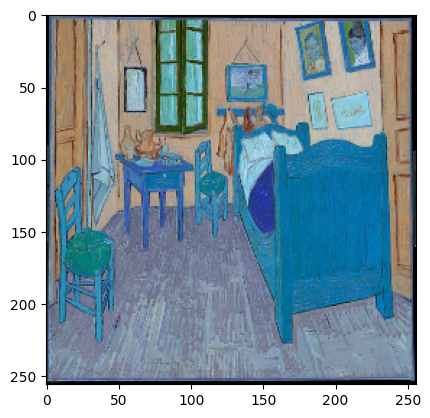

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 113ms/step


In [ ]:
yhat

array([[0.49809733]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Rembrandt')
else:
    print(f'Predicted class is Van Gogh')

Predicted class is Van Gogh


# 10. Save the Model

In [ ]:
model_path = '/content/drive/MyDrive/Art Classification'
model.save(model_path)
loaded_model = tf.keras.models.load_model(model_path)